In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Grid:
    def __init__(self):
        pass
        

In [3]:
grid = Grid()

In [71]:
def GridGen( nx, ny , r):

    grid.nx = nx
    grid.ny = ny

    xlength = 4
    dx = xlength/(nx-(nx+1)/2*(1-r))
    x = np.zeros(nx+1)
    x[0]=0
    for i in range(1,nx+1):
        x[i]=x[i-1]+dx*(1-(i-1)*(1-r)/nx)

    y = np.linspace(0,1.5,ny+1)
    y_ffb = 1.5
    grid.x = np.zeros((nx+1,ny+1))
    grid.y = np.zeros((nx+1,ny+1))
    for i in range(nx+1):
        for j in range(ny+1):
            grid.x[i,j] = x[i]
            grid.y[i,j] = y[j]

    ramp = 8
    for i in range(nx+1):
        if (grid.x[i,0] >= 0.5):
            grid.y[i,0] = grid.y[i,0] + (grid.x[i,0] - 0.5) * np.tan(ramp*np.pi/180)

    for i in range(nx+1):
        dy = grid.y[i,0]
        for j in range(1,ny+1):
            ratio = 1 - (grid.y[i,j]) / y_ffb
            deformation = dy * ratio
            grid.y[i,j] = grid.y[i,j] + deformation


    grid.xc = np.zeros((nx,ny))
    grid.yc = np.zeros((nx,ny))
    for i in range(nx):
        for j in range(ny):
            grid.xc[i,j] = 0.25 * ( grid.x[i,j] + grid.x[i+1,j] + grid.x[i+1,j+1] + grid.x[i,j+1] )
            grid.yc[i,j] = 0.25 * ( grid.y[i,j] + grid.y[i+1,j] + grid.y[i+1,j+1] + grid.y[i,j+1] )

    grid.area = np.zeros((nx,ny))
    for i in range(nx):
        for j in range(ny):
            grid.area[i,j] = 0.5 * np.abs(grid.x[i+1,j] * grid.y[i+1,j+1] + grid.x[i+1,j+1] * grid.y[i,j+1]
              + grid.x[i,j+1] * grid.y[i,j]     + grid.x[i,j] * grid.y[i+1,j]
              - grid.x[i+1,j+1] * grid.y[i+1,j] - grid.x[i,j+1] * grid.y[i+1,j+1]
              - grid.x[i,j] * grid.y[i,j+1]     - grid.x[i+1,j] * grid.y[i,j] )

    grid.edge = np.zeros((nx,ny,4))
    for i in range(nx):
        for j in range(ny):
            grid.edge[i,j,0] = np.sqrt( (grid.x[i+1,j+1] - grid.x[i+1,j])**2
                                   + (grid.y[i+1,j+1] - grid.y[i+1,j])**2 )
            grid.edge[i,j,1] = np.sqrt( (grid.x[i,j+1] - grid.x[i+1,j+1])**2
                                   + (grid.y[i,j+1] - grid.y[i+1,j+1])**2 )
            grid.edge[i,j,2] = np.sqrt( (grid.x[i,j] - grid.x[i,j+1])**2
                                   + (grid.y[i,j] - grid.y[i,j+1])**2 )
            grid.edge[i,j,3] = np.sqrt( (grid.x[i+1,j] - grid.x[i,j])**2
                                   + (grid.y[i+1,j] - grid.y[i,j])**2 )

    grid.normx = np.zeros((nx,ny,4))
    grid.normy = np.zeros((nx,ny,4))
    rot = np.array([[0,1],[-1,0]])
    for i in range(nx):
        for j in range(ny):
            v1 = np.array([[grid.x[i+1,j+1] - grid.x[i+1,j]],
                  [grid.y[i+1,j+1] - grid.y[i+1,j]]])
            v2 = np.array([[grid.x[i,j+1] - grid.x[i+1,j+1]],
                  [grid.y[i,j+1] - grid.y[i+1,j+1]]])
            v3 = np.array([[grid.x[i,j] - grid.x[i,j+1]],
                  [grid.y[i,j] - grid.y[i,j+1]]])
            v4 = np.array([[grid.x[i+1,j] - grid.x[i,j]],
                  [grid.y[i+1,j] - grid.y[i,j]]])

            v1 = np.matmul(rot, v1) / np.linalg.norm(v1);
            grid.normx[i,j,0] = v1[0];
            grid.normy[i,j,0] = v1[1];

            v2 = np.matmul(rot, v2) / np.linalg.norm(v2);
            grid.normx[i,j,1] = v2[0];
            grid.normy[i,j,1] = v2[1];

            v3 = np.matmul(rot,v3)/np.linalg.norm(v3);
            grid.normx[i,j,2] = v3[0];
            grid.normy[i,j,2] = v3[1];

            v4 = np.matmul(rot,v4)/np.linalg.norm(v4);
            grid.normx[i,j,3] = v4[0];
            grid.normy[i,j,3] = v4[1];
    return grid

In [113]:
# Extraction of physical quantities from W
def Wtovar(W):
    gamma = 1.4
    rho = W[0]
    u = W[1]/W[0]
    v = W[2]/W[0]
    E = W[3]
    P = (E-rho*(v*v+u*u)/2)*(gamma-1)
    h = (E+P)/rho
    return rho,u,v,E,P,h

In [114]:
# ARL matrix
def A_mat(h,u,v,nux,nuy,g):
    a1 = (g-3)*u*u*nux/2+(g-1)*v*v*nux/2-u*v*nuy
    a2 = (g-3)*v*v*nuy/2+(g-1)*u*u*nuy/2-u*v*nux
    a3 = (u*nux+v*nuy)*((g-1)*(u**2+v**2)/2-h)
    return np.array([[0,nux,nuy,0],
            [a1,(3-g)*u*nux+v*nuy,u*nuy-(g-1)*v*nux,(g-1)*nux],
            [a2,v*nux-(g-1)*u*nuy,u*nux+(3-g)*v*nuy,(g-1)*nuy],
    [a3,h*nux-u*(g-1)*(u*nux+v*nuy),h*nuy-v*(g-1)*(u*nux+v*nuy),g*(u*nux+v*nuy)]])

In [334]:
def Roe_flux(Wi,Wj,nij):
    n0ij = nij/np.linalg.norm(nij)
    rhoi,ui,vi,Ei,Pi,hi = Wtovar(Wi)
    rhoj,uj,vj,Ej,Pj,hj = Wtovar(Wj)
    uij = (np.sqrt(rhoi)*ui+np.sqrt(rhoj)*uj)/(np.sqrt(rhoi)+np.sqrt(rhoj))
    vij = (np.sqrt(rhoi)*vi+np.sqrt(rhoj)*vj)/(np.sqrt(rhoi)+np.sqrt(rhoj))
    hij = (np.sqrt(rhoi)*hi+np.sqrt(rhoj)*hj)/(np.sqrt(rhoi)+np.sqrt(rhoj))
    v0i = ui*n0ij[0]+vi*n0ij[1]
    v0j = uj*n0ij[0]+vj*n0ij[1]
    Aij = A_mat(hij,uij,vij,n0ij[0],n0ij[1],1.4)
    a,b = np.linalg.eig(Aij)
    Aij_mod = np.matmul(b,np.matmul(np.diag(np.abs(a)),np.linalg.inv(b)))
    F0i = np.array([rhoi*v0i,rhoi*ui*v0i+Pi*n0ij[0],rhoi*vi*v0i+Pi*n0ij[1],(Ei+Pi)*v0i])
    F0j = np.array([rhoj*v0j,rhoj*uj*v0j+Pj*n0ij[0],rhoj*vj*v0j+Pj*n0ij[1],(Ej+Pj)*v0j])
    F = ((F0i+F0j)-np.matmul(Aij_mod,(Wj-Wi)))*np.linalg.norm(nij)/2
    return F

In [661]:
def loop_global(grid,W):
    t = 0
    dt = 1e-5*4/60
    cfl = 0.1
    dx_min = grid.x[2,0]-grid.x[1,0]
    dy_min = grid.y[nx-1,1]-grid.y[nx-1,0]
    # while(t<T):
    # for m in range(10):
    maxF = 2500000000
    while(maxF/dt>25000000):
        maxF = 0.0
        for i in range(nx):
            for j in range(ny):
                rho[i,j],u[i,j],v[i,j],E[i,j],P[i,j],h[i,j] = Wtovar(W[i,j])
        a = np.sqrt(g*P/rho)
        try:
            dt = min(dx_min,dy_min)*cfl/(2*np.max(np.sqrt(u**2+v**2)+a))
        except:
            dt = 1e-5*4/60
        W1 = W.copy()
        for i in range(1,nx-1):
            for j in range(1,ny-1):
                ci = grid.area[i,j]
                F = 0
                F += grid.edge[i,j,0]*np.real(Roe_flux(W[i,j],W[i+1,j],[grid.normx[i,j,0],grid.normy[i,j,0]]))
                F += grid.edge[i,j,1]*np.real(Roe_flux(W[i,j],W[i,j+1],[grid.normx[i,j,1],grid.normy[i,j,1]]))
                F -= grid.edge[i,j,2]*np.real(Roe_flux(W[i,j],W[i-1,j],[grid.normx[i,j,2],grid.normy[i,j,2]]))
                F -= grid.edge[i,j,3]*np.real(Roe_flux(W[i,j],W[i,j-1],[grid.normx[i,j,3],grid.normy[i,j,3]]))
                W1[i,j] = W[i,j] - dt*F/ci
                maxF = max(maxF,F[0])
        for i in range(nx):
            j = 0
            ci = grid.area[i,j]
            F = 0
            if i == 0:
                F += grid.edge[i,j,0]*np.real(Roe_flux(W[i,j],W[i+1,j],[grid.normx[i,j,0],grid.normy[i,j,0]]))
                F += grid.edge[i,j,1]*np.real(Roe_flux(W[i,j],W[i,j+1],[grid.normx[i,j,1],grid.normy[i,j,1]]))
                F -= grid.edge[i,j,2]*np.real(Roe_flux(W[i,j],W0,[grid.normx[i,j,2],grid.normy[i,j,2]]))
                rhog,ug,vg,Eg,Pg,hg = Wtovar(W[i,j])
                na = grid.normx[i,j,3]
                nb = grid.normy[i,j,3]
                c = (-ug*(na**2-nb**2)-2*vg*na*nb)/(na**2+nb**2)
                d = (vg*(na**2-nb**2)-2*ug*na*nb)/(na**2+nb**2)
                Wg = np.array([rhog,rhog*c,rhog*d,Eg])
        #         Wg = np.array([rhog,-rhog*ug,-rhog*vg,Eg])
                F -= grid.edge[i,j,3]*np.real(Roe_flux(W[i,j],Wg,[grid.normx[i,j,3],grid.normy[i,j,3]]))
                W1[i,j] = W[i,j] - dt*F/ci
                maxF = max(maxF,F[0])
            elif i == nx-1:
                F -= grid.edge[i,j,2]*np.real(Roe_flux(W[i,j],W[i-1,j],[grid.normx[i,j,2],grid.normy[i,j,2]]))
                F += grid.edge[i,j,1]*np.real(Roe_flux(W[i,j],W[i,j+1],[grid.normx[i,j,1],grid.normy[i,j,1]]))
                F += grid.edge[i,j,0]*np.real(Roe_flux(W[i,j],W0,[grid.normx[i,j,0],grid.normy[i,j,0]]))
                rhog,ug,vg,Eg,Pg,hg = Wtovar(W[i,j])
                na = grid.normx[i,j,3]
                nb = grid.normy[i,j,3]
                c = (-ug*(na**2-nb**2)-2*vg*na*nb)/(na**2+nb**2)
                d = (vg*(na**2-nb**2)-2*ug*na*nb)/(na**2+nb**2)
                Wg = np.array([rhog,rhog*c,rhog*d,Eg])
        #         Wg = np.array([rhog,-rhog*ug,-rhog*vg,Eg])
                F -= grid.edge[i,j,3]*np.real(Roe_flux(W[i,j],Wg,[grid.normx[i,j,3],grid.normy[i,j,3]]))
                W1[i,j] = W[i,j] - dt*F/ci
                maxF = max(maxF,F[0])
            else:
                F += grid.edge[i,j,0]*np.real(Roe_flux(W[i,j],W[i+1,j],[grid.normx[i,j,0],grid.normy[i,j,0]]))
                F += grid.edge[i,j,1]*np.real(Roe_flux(W[i,j],W[i,j+1],[grid.normx[i,j,1],grid.normy[i,j,1]]))
                F -= grid.edge[i,j,2]*np.real(Roe_flux(W[i,j],W[i-1,j],[grid.normx[i,j,2],grid.normy[i,j,2]]))
                rhog,ug,vg,Eg,Pg,hg = Wtovar(W[i,j])
                na = grid.normx[i,j,3]
                nb = grid.normy[i,j,3]
                c = (-ug*(na**2-nb**2)-2*vg*na*nb)/(na**2+nb**2)
                d = (vg*(na**2-nb**2)-2*ug*na*nb)/(na**2+nb**2)
                Wg = np.array([rhog,rhog*c,rhog*d,Eg])
        #         Wg = np.array([rhog,-rhog*ug,-rhog*vg,Eg])
                F -= grid.edge[i,j,3]*np.real(Roe_flux(W[i,j],Wg,[grid.normx[i,j,3],grid.normy[i,j,3]]))
                W1[i,j] = W[i,j] - dt*F/ci
                maxF = max(maxF,F[0])
    #         W1[i,j] = np.array([rhog,0,0,Eg])
        for i in range(nx):
            j = ny-1
            ci = grid.area[i,j]
            F = 0
            if i == 0:
                F += grid.edge[i,j,0]*np.real(Roe_flux(W[i,j],W[i+1,j],[grid.normx[i,j,0],grid.normy[i,j,0]]))
                F -= grid.edge[i,j,3]*np.real(Roe_flux(W[i,j],W[i,j-1],[grid.normx[i,j,3],grid.normy[i,j,3]]))
                F -= grid.edge[i,j,2]*np.real(Roe_flux(W[i,j],W0,[grid.normx[i,j,2],grid.normy[i,j,2]]))
                rhog,ug,vg,Eg,Pg,hg = Wtovar(W[i,j])
                na = grid.normx[i,j,1]
                nb = grid.normy[i,j,1]
                c = (-ug*(na**2-nb**2)-2*vg*na*nb)/(na**2+nb**2)
                d = (vg*(na**2-nb**2)-2*ug*na*nb)/(na**2+nb**2)
                Wg = np.array([rhog,rhog*c,rhog*d,Eg])
        #         Wg = np.array([rhog,-rhog*ug,-rhog*vg,Eg])
                F += grid.edge[i,j,1]*np.real(Roe_flux(W[i,j],Wg,[grid.normx[i,j,1],grid.normy[i,j,1]]))
                W1[i,j] = W[i,j] - dt*F/ci
                maxF = max(maxF,F[0])
            elif i == nx-1:
                F -= grid.edge[i,j,2]*np.real(Roe_flux(W[i,j],W[i-1,j],[grid.normx[i,j,2],grid.normy[i,j,2]]))
                F -= grid.edge[i,j,3]*np.real(Roe_flux(W[i,j],W[i,j-1],[grid.normx[i,j,3],grid.normy[i,j,3]]))
                F += grid.edge[i,j,0]*np.real(Roe_flux(W[i,j],W0,[grid.normx[i,j,0],grid.normy[i,j,0]]))
                rhog,ug,vg,Eg,Pg,hg = Wtovar(W[i,j])
                na = grid.normx[i,j,1]
                nb = grid.normy[i,j,1]
                c = (-ug*(na**2-nb**2)-2*vg*na*nb)/(na**2+nb**2)
                d = (vg*(na**2-nb**2)-2*ug*na*nb)/(na**2+nb**2)
                Wg = np.array([rhog,rhog*c,rhog*d,Eg])
        #         Wg = np.array([rhog,-rhog*ug,-rhog*vg,Eg])
                F += grid.edge[i,j,1]*np.real(Roe_flux(W[i,j],Wg,[grid.normx[i,j,1],grid.normy[i,j,1]]))
                W1[i,j] = W[i,j] - dt*F/ci
                maxF = max(maxF,F[0])
            else:
                F += grid.edge[i,j,0]*np.real(Roe_flux(W[i,j],W[i+1,j],[grid.normx[i,j,0],grid.normy[i,j,0]]))
                F -= grid.edge[i,j,3]*np.real(Roe_flux(W[i,j],W[i,j-1],[grid.normx[i,j,3],grid.normy[i,j,3]]))
                F -= grid.edge[i,j,2]*np.real(Roe_flux(W[i,j],W[i-1,j],[grid.normx[i,j,2],grid.normy[i,j,2]]))
                rhog,ug,vg,Eg,Pg,hg = Wtovar(W[i,j])
                na = grid.normx[i,j,1]
                nb = grid.normy[i,j,1]
                c = (-ug*(na**2-nb**2)-2*vg*na*nb)/(na**2+nb**2)
                d = (vg*(na**2-nb**2)-2*ug*na*nb)/(na**2+nb**2)
                Wg = np.array([rhog,rhog*c,rhog*d,Eg])
        #         Wg = np.array([rhog,-rhog*ug,-rhog*vg,Eg])
                F += grid.edge[i,j,1]*np.real(Roe_flux(W[i,j],Wg,[grid.normx[i,j,1],grid.normy[i,j,1]]))
                W1[i,j] = W[i,j] - dt*F/ci
                maxF = max(maxF,F[0])
    #         W1[i,j] = np.array([rhog,0,0,Eg])
        for j in range(1,ny-1):
            i = 0
            ci = grid.area[i,j]
            F = 0
            F += grid.edge[i,j,1]*np.real(Roe_flux(W[i,j],W[i,j+1],[grid.normx[i,j,1],grid.normy[i,j,1]]))
            F -= grid.edge[i,j,3]*np.real(Roe_flux(W[i,j],W[i,j-1],[grid.normx[i,j,3],grid.normy[i,j,3]]))
            F += grid.edge[i,j,0]*np.real(Roe_flux(W[i,j],W[i+1,j],[grid.normx[i,j,0],grid.normy[i,j,0]]))
            F -= grid.edge[i,j,2]*np.real(Roe_flux(W[i,j],W0,[grid.normx[i,j,2],grid.normy[i,j,2]]))
            W1[i,j] = W[i,j] - dt*F/ci
            maxF = max(maxF,F[0])
        for j in range(1,ny-1):
            i = nx-1
            ci = grid.area[i,j]
            F = 0
            F += grid.edge[i,j,1]*np.real(Roe_flux(W[i,j],W[i,j+1],[grid.normx[i,j,1],grid.normy[i,j,1]]))
            F -= grid.edge[i,j,3]*np.real(Roe_flux(W[i,j],W[i,j-1],[grid.normx[i,j,3],grid.normy[i,j,3]]))
            F -= grid.edge[i,j,2]*np.real(Roe_flux(W[i,j],W[i-1,j],[grid.normx[i,j,2],grid.normy[i,j,2]]))
            F += grid.edge[i,j,0]*np.real(Roe_flux(W[i,j],W0,[grid.normx[i,j,0],grid.normy[i,j,0]]))
            W1[i,j] = W[i,j] - dt*F/ci
            maxF = max(maxF,F[0])
        err = np.max(np.abs(W[:,:,0]-W1[:,:,0]))
        W = W1.copy()
        t += dt
        qw.append(maxF/dt)
    return W

In [620]:
def init():
    nx = 60
    ny = 20
    P = 1e5*np.ones((nx,ny))
    M = 2*np.ones((nx,ny))
    T = 300*np.ones((nx,ny))
    R = 287
    g = 1.4
    rho = P/(R*T)
    a = np.sqrt(g*R*T)
    u = a*M
    v = np.zeros((nx,ny))
    E = P/(g-1)+0.5*rho*(u**2+v**2)
    W = np.array([rho.T,rho.T*u.T,rho.T*v.T,E.T]).T
    h = (E+P)/rho
    W0 = W[0,0]
    return nx,ny,P,M,T,R,g,rho,a,u,v,E,W,h,W0

In [660]:
def loop_local(grid,W):
    t = 0
    dt = 1e-5*4/60
    cfl = 0.1
    dx_min = grid.x[2,0]-grid.x[1,0]
    dy_min = grid.y[nx-1,1]-grid.y[nx-1,0]
    # while(t<T):
    # for m in range(10):
    maxF = 2500000000
    while(maxF>25000000):
        maxF = 0.0
        for i in range(nx):
            for j in range(ny):
                rho[i,j],u[i,j],v[i,j],E[i,j],P[i,j],h[i,j] = Wtovar(W[i,j])
        a = np.sqrt(g*P/rho)
        try:
            dt = min(dx_min,dy_min)*cfl/(2*np.max(np.sqrt(u**2+v**2)+a))
        except:
            dt = 1e-5*4/60
        W1 = W.copy()
        for i in range(1,nx-1):
            for j in range(1,ny-1):
                dx = grid.x[i+1,j]-grid.x[i,j]
                dy = grid.y[i,j+1]-grid.y[i,j]
                dt = min(dx,dy)*cfl/(2*(np.sqrt(u[i,j]**2+v[i,j]**2)+a[i,j]))
                ci = grid.area[i,j]
                F = 0
                F += grid.edge[i,j,0]*np.real(Roe_flux(W[i,j],W[i+1,j],[grid.normx[i,j,0],grid.normy[i,j,0]]))
                F += grid.edge[i,j,1]*np.real(Roe_flux(W[i,j],W[i,j+1],[grid.normx[i,j,1],grid.normy[i,j,1]]))
                F -= grid.edge[i,j,2]*np.real(Roe_flux(W[i,j],W[i-1,j],[grid.normx[i,j,2],grid.normy[i,j,2]]))
                F -= grid.edge[i,j,3]*np.real(Roe_flux(W[i,j],W[i,j-1],[grid.normx[i,j,3],grid.normy[i,j,3]]))
                W1[i,j] = W[i,j] - dt*F/ci
                maxF = max(maxF,F[0]/dt)
        for i in range(nx):
            j = 0
            ci = grid.area[i,j]
            F = 0
            if i == 0:
                dx = grid.x[i+1,j]-grid.x[i,j]
                dy = grid.y[i,j+1]-grid.y[i,j]
                dt = min(dx,dy)*cfl/(2*(np.sqrt(u[i,j]**2+v[i,j]**2)+a[i,j]))
                F += grid.edge[i,j,0]*np.real(Roe_flux(W[i,j],W[i+1,j],[grid.normx[i,j,0],grid.normy[i,j,0]]))
                F += grid.edge[i,j,1]*np.real(Roe_flux(W[i,j],W[i,j+1],[grid.normx[i,j,1],grid.normy[i,j,1]]))
                F -= grid.edge[i,j,2]*np.real(Roe_flux(W[i,j],W0,[grid.normx[i,j,2],grid.normy[i,j,2]]))
                rhog,ug,vg,Eg,Pg,hg = Wtovar(W[i,j])
                na = grid.normx[i,j,3]
                nb = grid.normy[i,j,3]
                c = (-ug*(na**2-nb**2)-2*vg*na*nb)/(na**2+nb**2)
                d = (vg*(na**2-nb**2)-2*ug*na*nb)/(na**2+nb**2)
                Wg = np.array([rhog,rhog*c,rhog*d,Eg])
        #         Wg = np.array([rhog,-rhog*ug,-rhog*vg,Eg])
                F -= grid.edge[i,j,3]*np.real(Roe_flux(W[i,j],Wg,[grid.normx[i,j,3],grid.normy[i,j,3]]))
                W1[i,j] = W[i,j] - dt*F/ci
                maxF = max(maxF,F[0]/dt)
            elif i == nx-1:
                dx = grid.x[i+1,j]-grid.x[i,j]
                dy = grid.y[i,j+1]-grid.y[i,j]
                dt = min(dx,dy)*cfl/(2*(np.sqrt(u[i,j]**2+v[i,j]**2)+a[i,j]))
                F -= grid.edge[i,j,2]*np.real(Roe_flux(W[i,j],W[i-1,j],[grid.normx[i,j,2],grid.normy[i,j,2]]))
                F += grid.edge[i,j,1]*np.real(Roe_flux(W[i,j],W[i,j+1],[grid.normx[i,j,1],grid.normy[i,j,1]]))
                F += grid.edge[i,j,0]*np.real(Roe_flux(W[i,j],W0,[grid.normx[i,j,0],grid.normy[i,j,0]]))
                rhog,ug,vg,Eg,Pg,hg = Wtovar(W[i,j])
                na = grid.normx[i,j,3]
                nb = grid.normy[i,j,3]
                c = (-ug*(na**2-nb**2)-2*vg*na*nb)/(na**2+nb**2)
                d = (vg*(na**2-nb**2)-2*ug*na*nb)/(na**2+nb**2)
                Wg = np.array([rhog,rhog*c,rhog*d,Eg])
        #         Wg = np.array([rhog,-rhog*ug,-rhog*vg,Eg])
                F -= grid.edge[i,j,3]*np.real(Roe_flux(W[i,j],Wg,[grid.normx[i,j,3],grid.normy[i,j,3]]))
                W1[i,j] = W[i,j] - dt*F/ci
                maxF = max(maxF,F[0]/dt)
            else:
                dx = grid.x[i+1,j]-grid.x[i,j]
                dy = grid.y[i,j+1]-grid.y[i,j]
                dt = min(dx,dy)*cfl/(2*(np.sqrt(u[i,j]**2+v[i,j]**2)+a[i,j]))
                F += grid.edge[i,j,0]*np.real(Roe_flux(W[i,j],W[i+1,j],[grid.normx[i,j,0],grid.normy[i,j,0]]))
                F += grid.edge[i,j,1]*np.real(Roe_flux(W[i,j],W[i,j+1],[grid.normx[i,j,1],grid.normy[i,j,1]]))
                F -= grid.edge[i,j,2]*np.real(Roe_flux(W[i,j],W[i-1,j],[grid.normx[i,j,2],grid.normy[i,j,2]]))
                rhog,ug,vg,Eg,Pg,hg = Wtovar(W[i,j])
                na = grid.normx[i,j,3]
                nb = grid.normy[i,j,3]
                c = (-ug*(na**2-nb**2)-2*vg*na*nb)/(na**2+nb**2)
                d = (vg*(na**2-nb**2)-2*ug*na*nb)/(na**2+nb**2)
                Wg = np.array([rhog,rhog*c,rhog*d,Eg])
        #         Wg = np.array([rhog,-rhog*ug,-rhog*vg,Eg])
                F -= grid.edge[i,j,3]*np.real(Roe_flux(W[i,j],Wg,[grid.normx[i,j,3],grid.normy[i,j,3]]))
                W1[i,j] = W[i,j] - dt*F/ci
                maxF = max(maxF,F[0]/dt)
    #         W1[i,j] = np.array([rhog,0,0,Eg])
        for i in range(nx):
            j = ny-1
            ci = grid.area[i,j]
            F = 0
            if i == 0:
                dx = grid.x[i+1,j]-grid.x[i,j]
                dy = grid.y[i,j+1]-grid.y[i,j]
                dt = min(dx,dy)*cfl/(2*(np.sqrt(u[i,j]**2+v[i,j]**2)+a[i,j]))
                F += grid.edge[i,j,0]*np.real(Roe_flux(W[i,j],W[i+1,j],[grid.normx[i,j,0],grid.normy[i,j,0]]))
                F -= grid.edge[i,j,3]*np.real(Roe_flux(W[i,j],W[i,j-1],[grid.normx[i,j,3],grid.normy[i,j,3]]))
                F -= grid.edge[i,j,2]*np.real(Roe_flux(W[i,j],W0,[grid.normx[i,j,2],grid.normy[i,j,2]]))
                rhog,ug,vg,Eg,Pg,hg = Wtovar(W[i,j])
                na = grid.normx[i,j,1]
                nb = grid.normy[i,j,1]
                c = (-ug*(na**2-nb**2)-2*vg*na*nb)/(na**2+nb**2)
                d = (vg*(na**2-nb**2)-2*ug*na*nb)/(na**2+nb**2)
                Wg = np.array([rhog,rhog*c,rhog*d,Eg])
        #         Wg = np.array([rhog,-rhog*ug,-rhog*vg,Eg])
                F += grid.edge[i,j,1]*np.real(Roe_flux(W[i,j],Wg,[grid.normx[i,j,1],grid.normy[i,j,1]]))
                W1[i,j] = W[i,j] - dt*F/ci
                maxF = max(maxF,F[0]/dt)
            elif i == nx-1:
                dx = grid.x[i+1,j]-grid.x[i,j]
                dy = grid.y[i,j+1]-grid.y[i,j]
                dt = min(dx,dy)*cfl/(2*(np.sqrt(u[i,j]**2+v[i,j]**2)+a[i,j]))
                F -= grid.edge[i,j,2]*np.real(Roe_flux(W[i,j],W[i-1,j],[grid.normx[i,j,2],grid.normy[i,j,2]]))
                F -= grid.edge[i,j,3]*np.real(Roe_flux(W[i,j],W[i,j-1],[grid.normx[i,j,3],grid.normy[i,j,3]]))
                F += grid.edge[i,j,0]*np.real(Roe_flux(W[i,j],W0,[grid.normx[i,j,0],grid.normy[i,j,0]]))
                rhog,ug,vg,Eg,Pg,hg = Wtovar(W[i,j])
                na = grid.normx[i,j,1]
                nb = grid.normy[i,j,1]
                c = (-ug*(na**2-nb**2)-2*vg*na*nb)/(na**2+nb**2)
                d = (vg*(na**2-nb**2)-2*ug*na*nb)/(na**2+nb**2)
                Wg = np.array([rhog,rhog*c,rhog*d,Eg])
        #         Wg = np.array([rhog,-rhog*ug,-rhog*vg,Eg])
                F += grid.edge[i,j,1]*np.real(Roe_flux(W[i,j],Wg,[grid.normx[i,j,1],grid.normy[i,j,1]]))
                W1[i,j] = W[i,j] - dt*F/ci
                maxF = max(maxF,F[0]/dt)
            else:
                dx = grid.x[i+1,j]-grid.x[i,j]
                dy = grid.y[i,j+1]-grid.y[i,j]
                dt = min(dx,dy)*cfl/(2*(np.sqrt(u[i,j]**2+v[i,j]**2)+a[i,j]))
                F += grid.edge[i,j,0]*np.real(Roe_flux(W[i,j],W[i+1,j],[grid.normx[i,j,0],grid.normy[i,j,0]]))
                F -= grid.edge[i,j,3]*np.real(Roe_flux(W[i,j],W[i,j-1],[grid.normx[i,j,3],grid.normy[i,j,3]]))
                F -= grid.edge[i,j,2]*np.real(Roe_flux(W[i,j],W[i-1,j],[grid.normx[i,j,2],grid.normy[i,j,2]]))
                rhog,ug,vg,Eg,Pg,hg = Wtovar(W[i,j])
                na = grid.normx[i,j,1]
                nb = grid.normy[i,j,1]
                c = (-ug*(na**2-nb**2)-2*vg*na*nb)/(na**2+nb**2)
                d = (vg*(na**2-nb**2)-2*ug*na*nb)/(na**2+nb**2)
                Wg = np.array([rhog,rhog*c,rhog*d,Eg])
        #         Wg = np.array([rhog,-rhog*ug,-rhog*vg,Eg])
                F += grid.edge[i,j,1]*np.real(Roe_flux(W[i,j],Wg,[grid.normx[i,j,1],grid.normy[i,j,1]]))
                W1[i,j] = W[i,j] - dt*F/ci
                maxF = max(maxF,F[0]/dt)
    #         W1[i,j] = np.array([rhog,0,0,Eg])
        for j in range(1,ny-1):
            i = 0
            dx = grid.x[i+1,j]-grid.x[i,j]
            dy = grid.y[i,j+1]-grid.y[i,j]
            dt = min(dx,dy)*cfl/(2*(np.sqrt(u[i,j]**2+v[i,j]**2)+a[i,j]))
            ci = grid.area[i,j]
            F = 0
            F += grid.edge[i,j,1]*np.real(Roe_flux(W[i,j],W[i,j+1],[grid.normx[i,j,1],grid.normy[i,j,1]]))
            F -= grid.edge[i,j,3]*np.real(Roe_flux(W[i,j],W[i,j-1],[grid.normx[i,j,3],grid.normy[i,j,3]]))
            F += grid.edge[i,j,0]*np.real(Roe_flux(W[i,j],W[i+1,j],[grid.normx[i,j,0],grid.normy[i,j,0]]))
            F -= grid.edge[i,j,2]*np.real(Roe_flux(W[i,j],W0,[grid.normx[i,j,2],grid.normy[i,j,2]]))
            W1[i,j] = W[i,j] - dt*F/ci
            maxF = max(maxF,F[0]/dt)
        for j in range(1,ny-1):
            i = nx-1
            dx = grid.x[i+1,j]-grid.x[i,j]
            dy = grid.y[i,j+1]-grid.y[i,j]
            dt = min(dx,dy)*cfl/(2*(np.sqrt(u[i,j]**2+v[i,j]**2)+a[i,j]))
            ci = grid.area[i,j]
            F = 0
            F += grid.edge[i,j,1]*np.real(Roe_flux(W[i,j],W[i,j+1],[grid.normx[i,j,1],grid.normy[i,j,1]]))
            F -= grid.edge[i,j,3]*np.real(Roe_flux(W[i,j],W[i,j-1],[grid.normx[i,j,3],grid.normy[i,j,3]]))
            F -= grid.edge[i,j,2]*np.real(Roe_flux(W[i,j],W[i-1,j],[grid.normx[i,j,2],grid.normy[i,j,2]]))
            F += grid.edge[i,j,0]*np.real(Roe_flux(W[i,j],W0,[grid.normx[i,j,0],grid.normy[i,j,0]]))
            W1[i,j] = W[i,j] - dt*F/ci
            maxF = max(maxF,F[0]/dt)
        W = W1.copy()
        t += dt
        qw.append(maxF)
    return W

In [662]:
grid = GridGen(60,20,1)

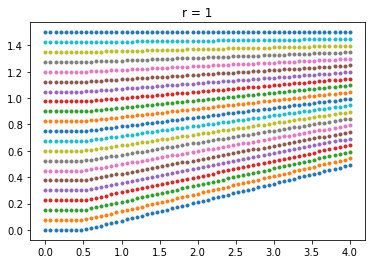

In [663]:
plt.plot(grid.x,grid.y,'.')
plt.title('r = 1')
plt.show()

In [664]:
qw = []
nx,ny,P,M,T,R,g,rho,a,u,v,E,W,h,W0 = init()
W = loop_global(grid,W)

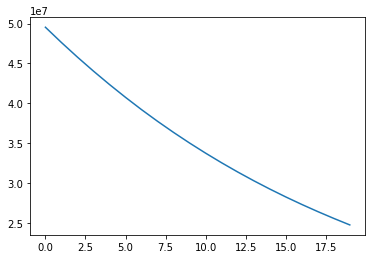

In [665]:
plt.plot(qw)

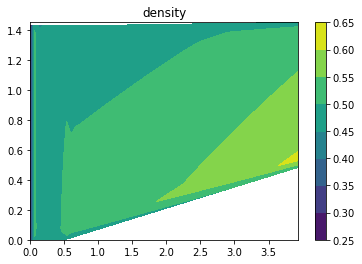

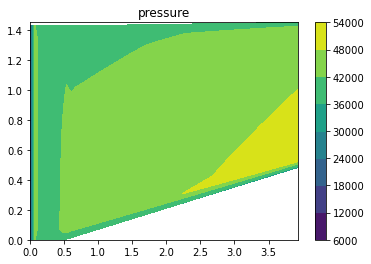

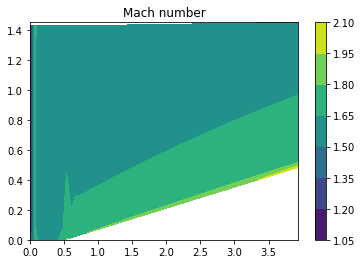

In [648]:
#### rho2 = np.zeros((nx,ny))
u2 = np.zeros((nx,ny))
v2 = np.zeros((nx,ny))
P2 = np.zeros((nx,ny))
for i in range(nx):
    for j in range(ny):
        rho2[i,j],u2[i,j],v2[i,j],_,P2[i,j],_ = Wtovar(W[i,j])
plt.contourf(grid.x[:nx,:ny],grid.y[:nx,:ny],rho2)
plt.title('density')
plt.colorbar()
plt.show()
plt.contourf(grid.x[:nx,:ny],grid.y[:nx,:ny],P2)
plt.title('pressure')
plt.colorbar()
plt.show()
plt.contourf(grid.x[:nx,:ny],grid.y[:nx,:ny],u2/np.sqrt(1.4*P2/rho2))
plt.title('Mach number')
plt.colorbar()
plt.show()

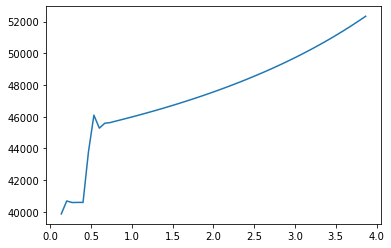

In [650]:
plt.plot(grid.x[:,0][2:nx-1],P2[:,1][2:nx-1])

In [666]:
qw = []
nx,ny,P,M,T,R,g,rho,a,u,v,E,W,h,W0 = init()
W = loop_local(grid,W)

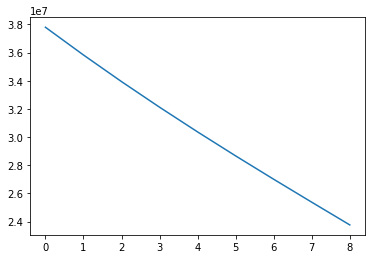

In [667]:
plt.plot(qw)

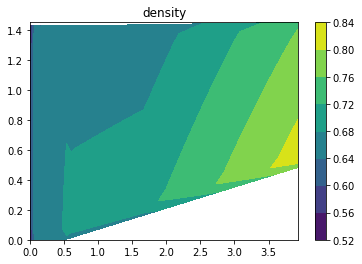

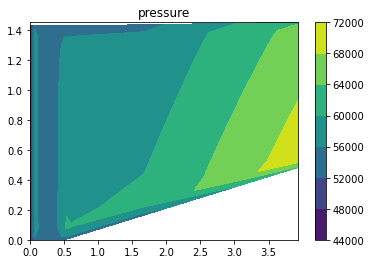

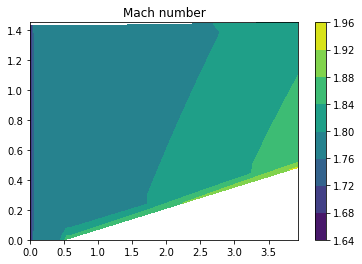

In [652]:
#### rho2 = np.zeros((nx,ny))
u2 = np.zeros((nx,ny))
v2 = np.zeros((nx,ny))
P2 = np.zeros((nx,ny))
for i in range(nx):
    for j in range(ny):
        rho2[i,j],u2[i,j],v2[i,j],_,P2[i,j],_ = Wtovar(W[i,j])
plt.contourf(grid.x[:nx,:ny],grid.y[:nx,:ny],rho2)
plt.title('density')
plt.colorbar()
plt.show()
plt.contourf(grid.x[:nx,:ny],grid.y[:nx,:ny],P2)
plt.title('pressure')
plt.colorbar()
plt.show()
plt.contourf(grid.x[:nx,:ny],grid.y[:nx,:ny],u2/np.sqrt(1.4*P2/rho2))
plt.title('Mach number')
plt.colorbar()
plt.show()

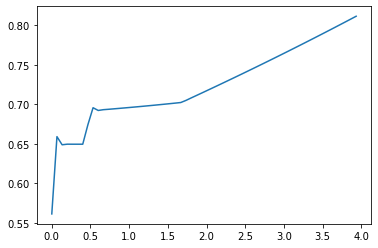

In [627]:
plt.plot(grid.x[:,0][:nx],rho2[:,3])

In [653]:
grid = GridGen(60,20,0.1)

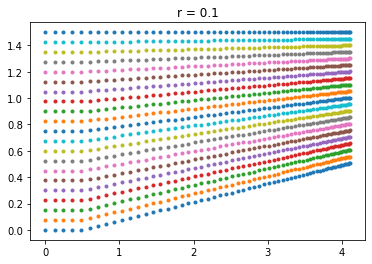

In [654]:
plt.plot(grid.x,grid.y,'.')
plt.title('r = 0.1')
plt.show()

In [655]:
nx,ny,P,M,T,R,g,rho,a,u,v,E,W,h,W0 = init()
W = loop_global(grid,W)

2.387149270494132e-06 50676209.1826735
4.781091964893839e-06 49402305.08796632
7.181766599224758e-06 48168902.45285154
9.58910955836011e-06 46974526.455968454
1.200305515902098e-05 45817754.03705195
1.4423535709753617e-05 44697211.6873271
1.6850481566600585e-05 43611573.30187615
1.9283821183102913e-05 42559558.08227183
2.172348115319109e-05 41539928.47671504
2.41693862454431e-05 40551488.143472046
2.662104552671773e-05 39599764.20721884
2.9078204322140094e-05 38679516.73181081
3.154062605448777e-05 37789207.74586206
3.400805649667003e-05 36927898.777356364
3.648022337687459e-05 36094675.69189236
3.895683607968934e-05 35288645.367961854
4.14375854622678e-05 34508932.09648575
4.3922143806582105e-05 33754673.631805524
4.641016493092496e-05 33025016.801563725
4.890128448612704e-05 32319112.55609327
5.1395120464522125e-05 31636110.301234618
5.3891273952633835e-05 30975151.307779897
5.6389330162048226e-05 30335360.919917207
5.888885977723366e-05 29715839.185004245
6.138942066454805e-05 29115

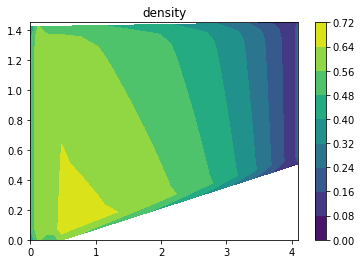

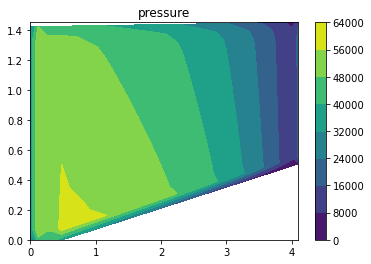

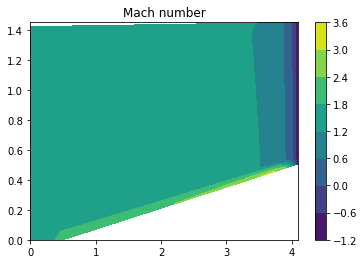

In [656]:
#### rho2 = np.zeros((nx,ny))
u2 = np.zeros((nx,ny))
v2 = np.zeros((nx,ny))
P2 = np.zeros((nx,ny))
for i in range(nx):
    for j in range(ny):
        rho2[i,j],u2[i,j],v2[i,j],_,P2[i,j],_ = Wtovar(W[i,j])
plt.contourf(grid.x[:nx,:ny],grid.y[:nx,:ny],rho2)
plt.title('density')
plt.colorbar()
plt.show()
plt.contourf(grid.x[:nx,:ny],grid.y[:nx,:ny],P2)
plt.title('pressure')
plt.colorbar()
plt.show()
plt.contourf(grid.x[:nx,:ny],grid.y[:nx,:ny],u2/np.sqrt(1.4*P2/rho2))
plt.title('Mach number')
plt.colorbar()
plt.show()

In [658]:
nx,ny,P,M,T,R,g,rho,a,u,v,E,W,h,W0 = init()
W = loop_local(grid,W)

6.784064913520063e-07 117994209.8145458
1.362631824946249e-06 107750389.23230734
2.0528183900280826e-06 98388293.67424342
2.749114316756577e-06 89832023.05099615
3.451673788309156e-06 82012227.58662188
4.160657373593525e-06 74865540.38103473
4.876232382063291e-06 68334059.33175926
5.59857324223204e-06 62364874.10344244
6.32786190557965e-06 56920356.280367434
7.064288277641916e-06 52062226.64252218
7.808050678167042e-06 47613995.9629778
8.559356332305722e-06 43541200.94730899
9.318421894869512e-06 39812276.0119955
1.0085474009736792e-05 36398309.32234839
1.0860749906496247e-05 33272819.415149767
1.1644498036379858e-05 30411550.664488927
1.2436978749431802e-05 27792285.99695107
1.3238465014661024e-05 25394675.39740865
1.4049243184599688e-05 23200078.870251972


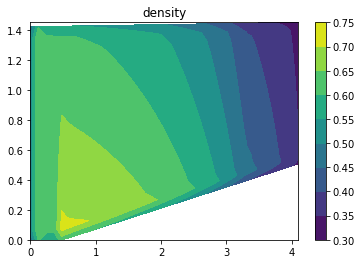

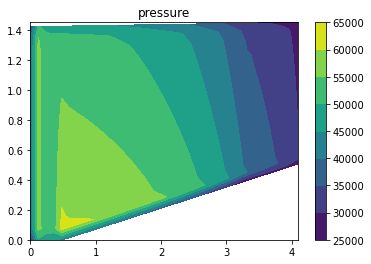

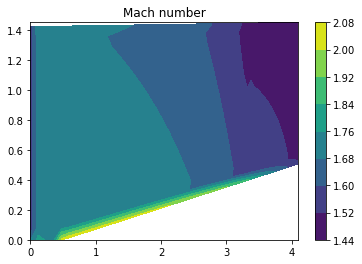

In [659]:
#### rho2 = np.zeros((nx,ny))
u2 = np.zeros((nx,ny))
v2 = np.zeros((nx,ny))
P2 = np.zeros((nx,ny))
for i in range(nx):
    for j in range(ny):
        rho2[i,j],u2[i,j],v2[i,j],_,P2[i,j],_ = Wtovar(W[i,j])
plt.contourf(grid.x[:nx,:ny],grid.y[:nx,:ny],rho2)
plt.title('density')
plt.colorbar()
plt.show()
plt.contourf(grid.x[:nx,:ny],grid.y[:nx,:ny],P2)
plt.title('pressure')
plt.colorbar()
plt.show()
plt.contourf(grid.x[:nx,:ny],grid.y[:nx,:ny],u2/np.sqrt(1.4*P2/rho2))
plt.title('Mach number')
plt.colorbar()
plt.show()